In [169]:
%matplotlib inline

# Exploring the ideas of Random Matrix theory
### Dataset : BCI Motor Imagery IV 2a
Remember to install the following packages
- pyRiemann
- MNE
- Those that come with Anaconda (matplotlib, numpy, sklearn, etc)

In [170]:
# import the basic python packages
import numpy as np
import matplotlib.pyplot as plt

# import the pyRiemann package and its modules
from pyriemann.utils.distance import distance_riemann, distance_euclid
from pyriemann.estimation import Covariances

# import the utilities modules
from utilities.data_handler import get_bci_mi_dataset, get_alpha_waves_dataset
from utilities.data_process import make_distance_matrix, make_laplacian_matrix

The examples in this notebook come from a dataset with EEG signals from BCI. The experimental paradigm is **not important**, all we need to know is that each experimental trial belongs to one of four classes. We have 72 trials for each of 4 classes.

The signals are multivariate time-series and are **assumed** Gaussian and wide-sense stationary. This means that each trial can be denoted as $X_i \in \mathbb{R}^{n \times T}$ ($n$ is the number of electrodes, $T$ is the number of time samples) and its statistics can be described by a mean $\mu_i$ and a covariance matrix $C_i$. 

NB: the **pre-processing** of the signals involves a bandpass filtering between 8 and 35 Hz (where there is actual neurophysiological information) which ends up zeroing the mean of the time series always to zero, so $\mu_i = 0$ for all trials.

In [171]:
# get the BCI dataset and select just two classes
X, y = get_bci_mi_dataset(subject=3)
sel = (y == 1) | (y == 2) 
X, y = X[sel], y[sel]
idx = np.concatenate([np.where(y == 1)[0], np.where(y == 2)[0]]) 
X, y = X[idx], y[idx]

# estimate the covariance matrix associate to each trial
covs = Covariances().fit_transform(X)

We'll start the analysis by calculating the matrix with all pairwise distances between the trials. We consider two different distances, one that simply takes the Euclidean distance $\delta_E$ between the samples of each trial $X_i$ and $X_j$,

$$
\delta^2_E(X_i, X_j) = \|X_i - X_j\|_F^2,
$$

and the Riemannian distance $\delta_R$ between the covariance matrices $C_i$ and $C_j$ associated to the trials,

$$
\delta^2_R(X_i, X_j) = \|\log(C_i^{-1/2}C_jC_i^{-1/2})\|_F^2.
$$


In [172]:
dm_euc = make_distance_matrix(points=X, distance=distance_euclid)
dm_rie = make_distance_matrix(points=covs, distance=distance_riemann)

Plot the heat maps showing the patterns for the distance matrices. One would **expect** to see two blocks of values, since the trials from same class should be near to each other

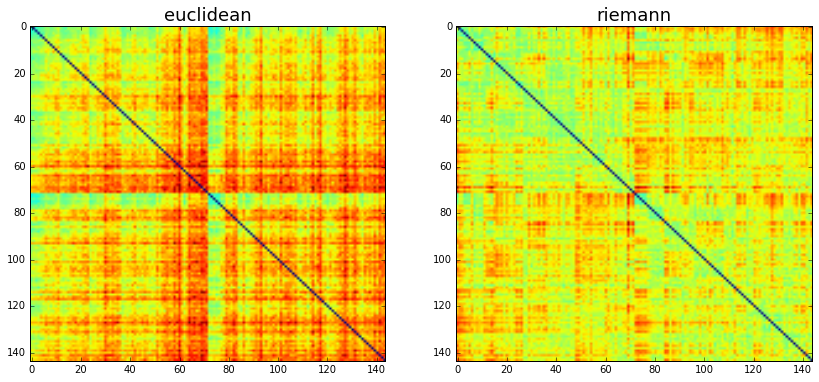

In [173]:
fig, ax = plt.subplots(facecolor='white', figsize=(14,6), ncols=2)
for axi, dmatrix, label in zip(ax, [dm_euc, dm_rie], ['euclidean', 'riemann']):
    axi.imshow(dmatrix, aspect='auto')
    axi.set_title(label, fontsize=18)

Plotting the **histogram** of both distance matrices. Note that they are both unimodal, which seems in accordance with the $\tau$ result from Romain's paper and also what we see in the heat maps above

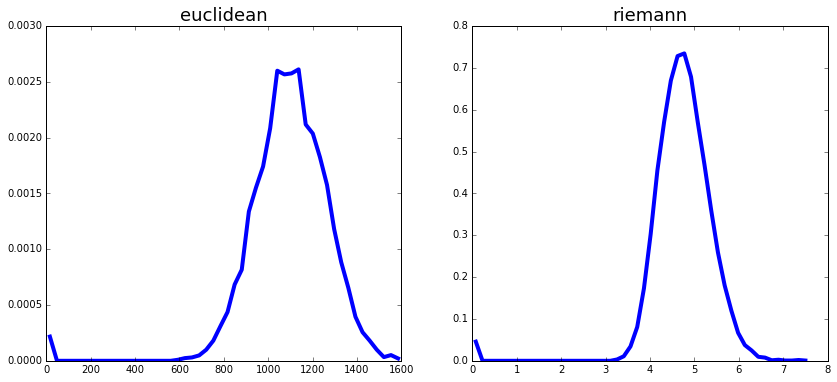

In [174]:
fig, ax = plt.subplots(facecolor='white', figsize=(14,6), ncols=2)
for axi, dmatrix, label in zip(ax, [dm_euc, dm_rie], ['euclidean', 'riemann']):
    hist, bins = np.histogram(dmatrix.flatten(), density=True, bins=50)
    axi.plot((bins[1:]+bins[:-1])/2, hist, lw=4.0)
    axi.set_title(label, fontsize=18)

Now we calculate the Laplacian matrix for each dataset to get their **spectral** embeddings

In [175]:
# loop through the distance matrices
u = []
L = []
for dmatrix in [dm_euc, dm_rie]:

    # heuristic for the eps parameter in the gaussian kernel
    eps = 2*np.median(dmatrix)**2
    K = np.exp(-dmatrix**2/eps)

    # make the Laplacian matrix and decompose it
    Ld = make_laplacian_matrix(kernel_matrix=K)
    ud,s,v = np.linalg.svd(Ld)

    L.append(Ld)
    u.append(ud)
    
u_euc, u_rie = u    
L_euc, L_rie = L

Scatter plots with the spectral embedding of each type of distance matrix 

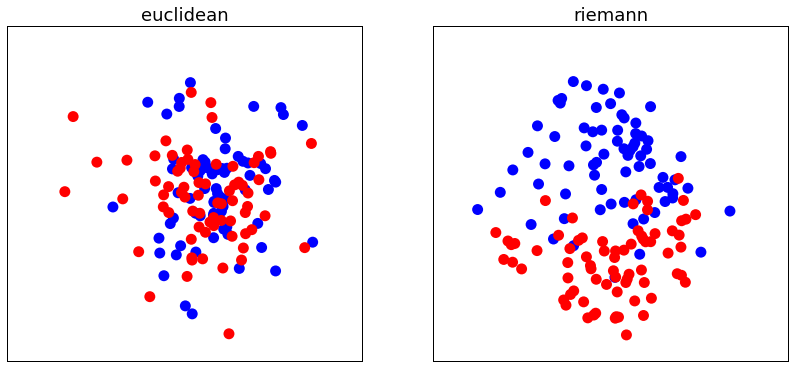

In [176]:
fig, ax = plt.subplots(facecolor='white', figsize=(14,6), ncols=2)
for axi, uspec, label in zip(ax, [u_euc, u_rie], ['euclidean', 'riemann']):
    dimx = 1; dimy = 2
    axi.scatter(uspec[y == 1, dimx], uspec[y == 1, dimy], s=120, edgecolor='none', facecolor='b')
    axi.scatter(uspec[y == 2, dimx], uspec[y == 2, dimy], s=120, edgecolor='none', facecolor='r')
    axi.set_xticks([])
    axi.set_yticks([]) 
    axi.set_title(label, fontsize=18)

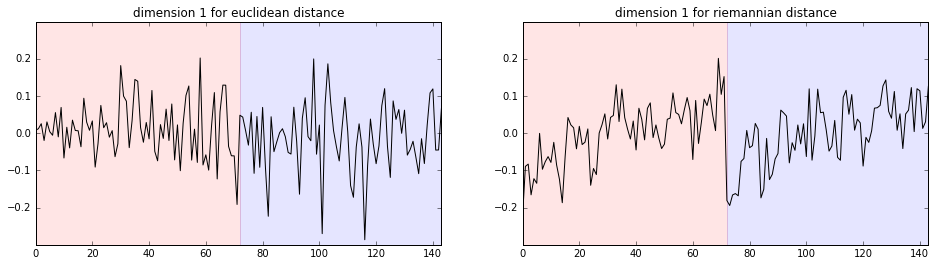

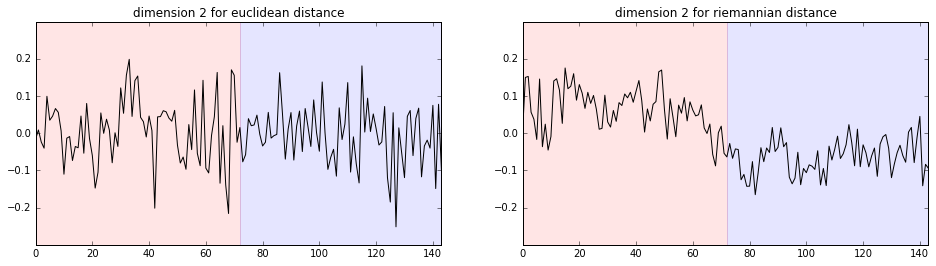

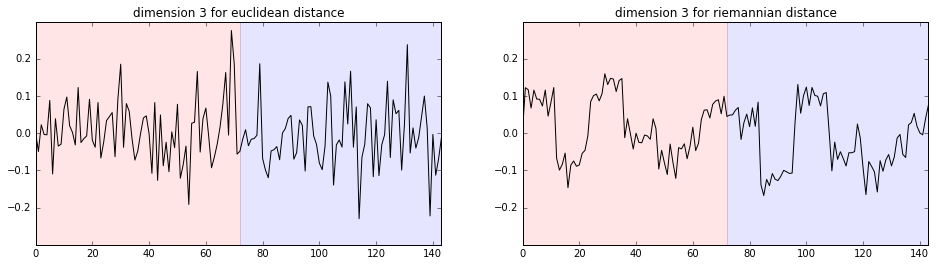

In [177]:
for dim in [1, 2, 3]:
    fig, ax = plt.subplots(figsize=(16,4), ncols=2)
    ax[0].plot(u_euc[:,dim], lw=1.0, c='k')
    ax[0].axvspan(0, len(y)/2, alpha=0.10, color='red')
    ax[0].axvspan(len(y)/2, len(y)-1, alpha=0.10, color='blue')
    ax[0].set_ylim(-0.3, +0.3)
    ax[0].set_xlim(0, len(y)-1)
    ax[0].set_title('dimension ' + str(dim) + ' for euclidean distance')    
    ax[1].plot(u_rie[:,dim], lw=1.0, c='k')
    ax[1].axvspan(0, len(y)/2, alpha=0.10, color='red')
    ax[1].axvspan(len(y)/2, len(y)-1, alpha=0.10, color='blue')
    ax[1].set_ylim(-0.3, +0.3)
    ax[1].set_xlim(0, len(y)-1)
    ax[1].set_title('dimension ' + str(dim) + ' for riemannian distance')

Let's now play a bit with the choice of kernels in a principled manner. They will all have the same form 

$$K = \left\{f(d(X_i, X_j)^2)\right\}$$

where $d(\cdot, \cdot)$ is the distance of choice to compare elements of a dataset and $f: \mathbb{R}^{+} \to \mathbb{R}^{+}$ is a three-times differentiable function such that 

$$f'(\tau) = 0 \text{ and } f''(\tau) \neq 0$$ 

with $\tau$ being the constant to where the square of all the pairwise distances converge according to Romain's work.

To make things simpler at first, let's consider the case with a **normalized** version of the samples $X_i$,

$$X'_i = \frac{X_i}{\|X_i\|}$$

Here we have $\tau = 2$ (why?) and then the kernel can be simply written as

$$K = \left\{\big(\|X'_i - X'_j\|_{F}^2 - 2\big)^2 \right\}$$

Note that we have a **fourth power** of the distance here !

In [178]:
# defining the normalized version of the samples
Xn = np.stack([Xi/np.linalg.norm(Xi) for Xi in X])

# build the distance matrix
distance_matrix = make_distance_matrix(points=Xn, distance=distance_euclid)

Let's check the histogram to be sure that the squared distances indeed converge to something near to $\tau = 2$

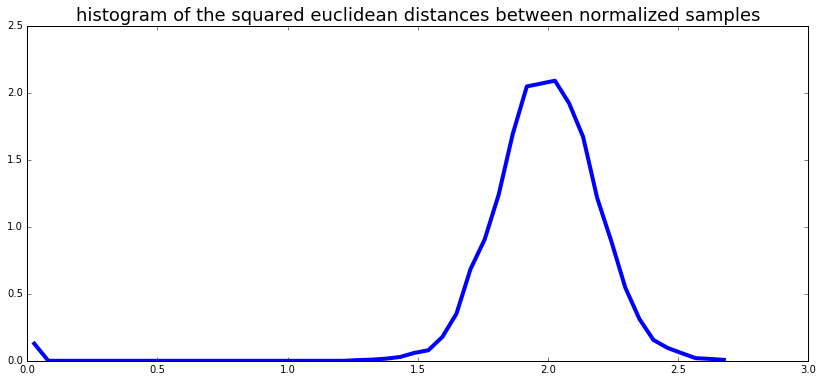

In [179]:
distance_matrix_sq = np.power(distance_matrix, 2)
fig, ax = plt.subplots(facecolor='white', figsize=(14,6))
hist, bins = np.histogram(distance_matrix_sq.flatten(), density=True, bins=50)
ax.plot((bins[1:]+bins[:-1])/2, hist, lw=4.0)
ax.set_title('histogram of the squared euclidean distances between normalized samples', fontsize=18)

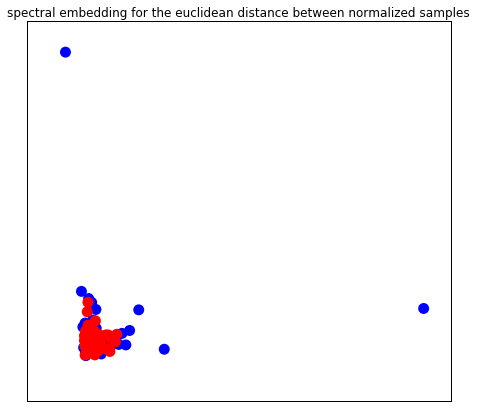

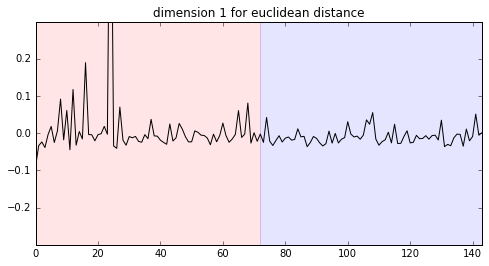

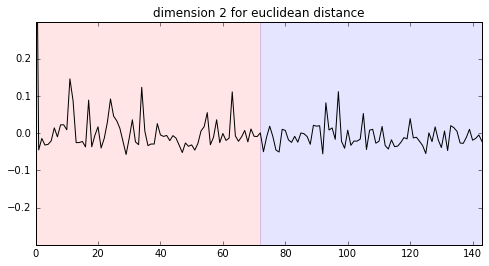

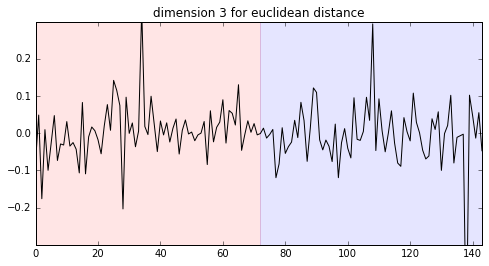

In [180]:
# use the polynomial kernel 
K = np.power(distance_matrix**2 - 2, 2)

# use the gaussian kernel
# std = np.std(distance_matrix**2)
# K = np.exp(-K/(2*std**2))

# make the Laplacian matrix and decompose it
L = make_laplacian_matrix(kernel_matrix=K)
u,s,v = np.linalg.svd(L)

# scatter plot with the spectral embedding
fig, ax = plt.subplots(facecolor='white', figsize=(7.6, 6.8))
dimx = 1; dimy = 2
ax.scatter(u[y == 1, dimx], u[y == 1, dimy], s=120, edgecolor='none', facecolor='b')
ax.scatter(u[y == 2, dimx], u[y == 2, dimy], s=120, edgecolor='none', facecolor='r')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("spectral embedding for the euclidean distance between normalized samples")

# plot the eigenvectors
for dim in [1, 2, 3]:
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(u[:,dim], lw=1.0, c='k')
    ax.axvspan(0, len(y)/2, alpha=0.10, color='red')
    ax.axvspan(len(y)/2, len(y)-1, alpha=0.10, color='blue')
    ax.set_ylim(-0.3, +0.3)
    ax.set_xlim(0, len(y)-1)
    ax.set_title('dimension ' + str(dim) + ' for euclidean distance')    

Now let's try to use the $\tau$ idea for the case of Riemannian distance between SPD matrices. From the **histogram** done before for the pairwise distance, we see that the squared distances do converge to around a constant. We'll now use a polynomial kernel around this value of $\tau$ taken as the median of the pairwise squared distances.

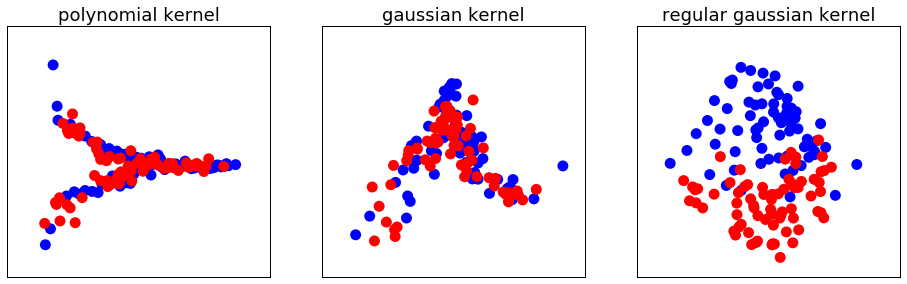

In [181]:
# from the histogram of dm_rie we see that the distances converge to some value
tau = np.median(dm_rie**2)

# use the polynomial kernel with tau
Kpoly = np.power(dm_rie**2 - tau, 2)

# use the gaussian kernel with tau
std = np.std(dm_rie**2)
Kexp1 = np.exp(-(dm_rie**2-tau)**2/(2*std**2)) 

# use regular gaussian kernel
eps = 2*np.median(dm_rie)**2
Kexp2 = np.exp(-dm_rie**2/eps) 

# make the Laplacian matrix for each case and decompose it
Lpoly = make_laplacian_matrix(kernel_matrix=Kpoly)
upoly,_,_ = np.linalg.svd(Lpoly)
Lexp1 = make_laplacian_matrix(kernel_matrix=Kexp1)
uexp1,_,_ = np.linalg.svd(Lexp1)
Lexp2 = make_laplacian_matrix(kernel_matrix=Kexp2)
uexp2,_,_ = np.linalg.svd(Lexp2)

# scatter plot with the spectral embedding
fig, ax = plt.subplots(facecolor='white', figsize=(16,4.5), ncols=3)
for axi, uspec, label in zip(ax, [upoly, uexp1, uexp2], ['polynomial kernel', 'gaussian kernel', 'regular gaussian kernel']):
    dimx = 1; dimy = 2
    axi.scatter(uspec[y == 1, dimx], uspec[y == 1, dimy], s=120, edgecolor='none', facecolor='b')
    axi.scatter(uspec[y == 2, dimx], uspec[y == 2, dimy], s=120, edgecolor='none', facecolor='r')
    axi.set_xticks([])
    axi.set_yticks([]) 
    axi.set_title(label, fontsize=18)

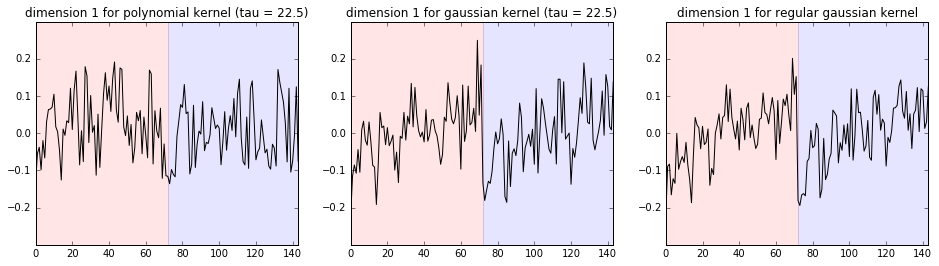

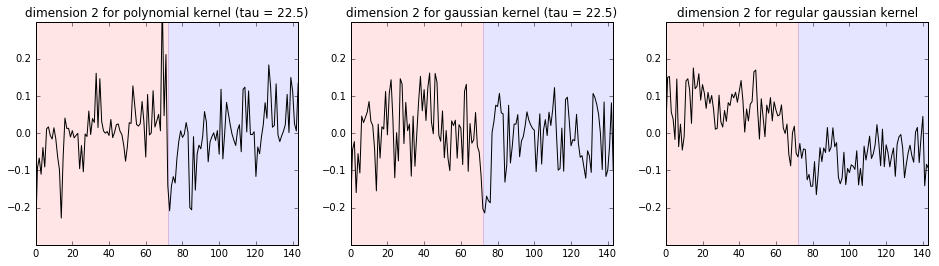

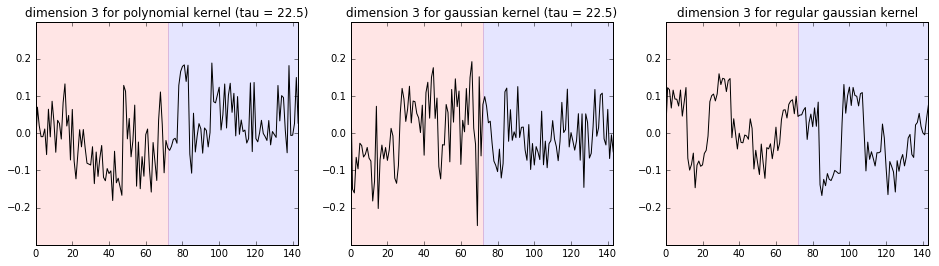

In [182]:
for dim in [1, 2, 3]:
    fig, ax = plt.subplots(figsize=(16,4), ncols=3)

    ax[0].plot(upoly[:,dim], lw=1.0, c='k')
    ax[0].axvspan(0, len(y)/2, alpha=0.10, color='red')
    ax[0].axvspan(len(y)/2, len(y)-1, alpha=0.10, color='blue')
    ax[0].set_ylim(-0.3, +0.3)
    ax[0].set_xlim(0, len(y)-1)
    ax[0].set_title('dimension ' + str(dim) + ' for polynomial kernel (tau = {0:.1f})'.format(tau))    

    ax[1].plot(uexp1[:,dim], lw=1.0, c='k')
    ax[1].axvspan(0, len(y)/2, alpha=0.10, color='red')
    ax[1].axvspan(len(y)/2, len(y)-1, alpha=0.10, color='blue')
    ax[1].set_ylim(-0.3, +0.3)
    ax[1].set_xlim(0, len(y)-1)
    ax[1].set_title('dimension ' + str(dim) + ' for gaussian kernel (tau = {0:.1f})'.format(tau))

    ax[2].plot(uexp2[:,dim], lw=1.0, c='k')
    ax[2].axvspan(0, len(y)/2, alpha=0.10, color='red')
    ax[2].axvspan(len(y)/2, len(y)-1, alpha=0.10, color='blue')
    ax[2].set_ylim(-0.3, +0.3)
    ax[2].set_xlim(0, len(y)-1)
    ax[2].set_title('dimension ' + str(dim) + ' for regular gaussian kernel'.format(tau))   